Problem and data obtained from Topcoder: https://goo.gl/Z2yAc1

Data: expressions_example.csv (FPKM-normalized gene expression data); copynumber_example.csv (log-2 scaled ratio between tumor and normal tissue); mutations_example.csv (boolean matrix indicating whether the gene is mutated or not; groundtruth_example.csv (a ground truth table containing when a sample's myeloma progressed and how long they were observed for)

Goal: Create an algorithm that can rank-order patients based on when their myeloma will progress.

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as sa
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

os.chdir("/Users/arudhir/Desktop/datascience/gen/data-science")

In [2]:
%load_ext rpy2.ipython
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [65]:
exp_ = pd.read_csv("expressions_example.csv")
cop_ = pd.read_csv("copynumber_example.csv")
mut_ = pd.read_csv("mutations_example.csv")
labels_ = pd.read_csv("groundtruth_example.csv")

Let's take a peek at the data to see what we're dealing with.

Some preliminary information about the data:
* 332 patients
* 18898 genes
* No controls given
* exp_ are RNA-Seq values normalized by FPKM (Fragments Per Kilobase per Million of reads) — MEASURES EXPRESSION NOT TRANSCRIPTION BECAUSE OF THE FPKM NORMALIZATION)
* cop_ values represent the log-2 scaled ratio between tumor and normal tissue. 0 means no copy change, negative values are deletions, and positive values are amplifications.


In [ ]:
display(exp_.head())
display(cop_.head())
display(mut_.head())
display(labels_)

**A few things to note**:
1. Different patients are missing different parts of the data
2. Expression data requires feature scaling
3. We'll need a way to handle the missing TP values
4. A number of patients are missing both TP and TO data — although we know that they have multiple myeloma
5. There is a **lot** of data — feature selection will probably need to happen.
6. The features are named the same across csv files
7. exp and cop need to either drop NA values or impute, and exp needs to be scaled

**Initial questions**:
1. Given that there are a lot of papers that draw conclusions using *just* the expression data — how can we use the mutation data and relative copy number data intelligently? -use mutation variance to select genes using genefilter, and use high/low copy # differences as a flag - both compared to the other genes in the patient and between patients
2. How do we incorporate the genetic information of the double NaN samples? -find similarities between just them by clustering or something so we can at least try and squeeze out relevant information
3. Is there a way to feature scale expression data without losing information? I feel as if biological data is really sensitive to transformations.
4. How can we make sure we don't introduce bias when selecting variables/methods/scoring methods/etc.
5. What are standard ways to deal with a system with such large, inherent nonlinearity?
6. Does FPKM normalization normalize between samples? 

**Initial ideas**:
1. The relative copy number data can be used to detect anomalies relative to both the other genes in the patient **and** across the same gene in all the patients; one finds potential oncogenes/tumor suppressor genes, the other finds unique differences between each patient that can be utilized to help us ultimately rank them.
2. Mutation data can be used to screen genes by: looking at mutations that exist across a significant portion of patients; looking at mutations that are unique to a patient compared to the others (i.e., genes that show significant variance between samples).
3. LASSO and Random Forests to feature select
4. Survival analysis and AFT to predict lifetimes
5. It is probably worth trying to combine all of the data into one large dataframe and lazily throw it into a RF or do PCA on it or something just to see how it performs — at least to get some sort of base model.

# Cleaning/Formatting the Data

1/23/17: I've foolishly been playing around with the data for weeks now with just a surface-level understanding of FPKM. But this will make future statistics on this data more legitimate. Here are some notes:

* First, microarray data has a continuous distribution — we need a discrete probability distribution. Poisson or negative binomial distributions are typically used — to apply a generalized linear model (GLM), [5] suggests a modeling the data with a negative binomial distribution. 
    
    * "One aspect of this is that, because RNA-seq is a sampling procedure, there is a certain amount of “real estate” (the total number of all reads from the sequencing instrument) that the actual transcripts in the sequencing library have to “share.” This means that highly expressed transcripts will often make up a large amount of the sequencing library, and in a shallow sequencing experiment less expressed genes may not be represented in the final data even though they were present." - *RNA-seq Data Analysis: A Practical Approach (Chapman & Hall/CRC Mathematical and Computational Biology)* 
 

* We are assuming it is okay to treat the patients as biological replicates of each other.

**FPKM (Fragments Per Kilobase Million)**
* For paired end RNA-seq — just keeps track of fragments so we don't double count (otherwise it's the same as RPKM
    
* Normalize read counts for:
    
    1. Sequencing depth (greater sequencing depth leads to more reads for each gene; million)
    
        * i.e., for each gene in a sample, divide the read count by the sum of all the read counts for that sample
        
    2. The length of the gene (longer genes = more reads; kilobase)
        
        * next, divide by the size of the gene — done.
* "As a unit of measurement for an estimate, what FPKM really refers to is the expected number of fragments per kilboase[sic] of transcript per million reads."


This is how measurements used to be normalized. But recently, there's a superior normalization method:

**TPM (Transcripts Per Kilobase Million)**
    1. Normalize for length 
    2. Normalize for sequencing depth

* It is the same thing but in a different order. This actually matters — look at the youtube video [4] for an example. Imagine a pie chart, and your TPM/RPKM values represent how big each pie slice is. With TPM, each pie is the same size, so it's easy to compare (size of the pie = total number of reads). In RPKM, this pie is a different size for each sample, so it's harder to compare. RNA-seq is all about comparing the relative proportions of reads, so this metric makes more sense.

* "TPMs, which effectively normalize for the differences in composition of the transcripts in the denominator rather than simply dividing by the number of reads in the library, are considered more comparable between samples of different origins and composition but can still suffer some biases. These must be addressed with normalization techniques such as TMM." [1]

* Converting between FPKM and TPM: [2] [3] 

* FPKM and TPM still only find the *relative* measures of expression and cannot be compared between samples. There needs to be another degree of normalization to make the values absolute. This is a much harder task, but luckily, packages exist: 

    * Package to find TMM: https://bioconductor.org/packages/release/bioc/html/edgeR.html — This has a lot of other potentially useful functions to help with differential gene expression analysis! Although the practice persists, using RPKM data as input (by the way, you'd have to round it to an integer because edgeR expects read counts (ints)) is highly discouraged [5]. PROBLEM: I don't think we have the information (right away) to get TMM. Although, I wonder if we can leverage the mutation file as a way to estimate absolute copy number.


[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4728800/

[2] https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/

[3] https://arxiv.org/pdf/1104.3889v2.pdf

[4] https://www.youtube.com/watch?v=TTUrtCY2k-w

[5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702322/pdf/12864_2015_Article_2353.pdf

[6] https://liorpachter.wordpress.com/tag/fpkm/ — blog of the author on [3]

Bias of FPKM: http://link.springer.com/article/10.1007/s12064-012-0162-3

https://support.bioconductor.org/p/69433/

**Note:** Remember to eliminate low read count genes to avoid having them get flagged as differentially expressed [5]; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4702322/pdf/12864_2015_Article_2353.pdf supplementary materials goes over ways to find the expression threshold for RPKM and TMM values

In [66]:
exp = exp_.add_suffix("_e")
cop = cop_.add_suffix("_c")
mut = mut_.add_suffix("_m")

labels = labels_.dropna(axis=0, how='all')
labels['P'] = ~np.isnan(labels['TP']) # Adds a boolean column to indicate whether the myeloma has progressed or not

We have to decide how to handle the missing expression data. I think there is a potential to make more intelligent imputation choices by using the rel. copy number data across patients and genes to scale it. But this sounds complicated, convoluted, and statistically dubious, so for now, let's just get rid of all NaN values. 

In [67]:
exp = exp.dropna(axis=0, how='all')
cop = cop.dropna(axis=0, how='all')
mut = mut.dropna(axis=0, how='all')

Let's scale the expression data too. There are more complicated schemes to feature scale microarray data (a least-squares approach is explored here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4028811/) but again for now, simplicity.

In [68]:
from functools import wraps
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer

def transformWrapper(transformer):
    '''
    Wraps an sklearn transformer so that transformations retain indices and column names.
    TODO: Try and make compatible with sklearn.pipeline
    '''
    def fitTransformKeepNames(data, *args, **kwargs):
        idx, col = data.index, data.columns
        ret = pd.DataFrame(transformer(*args, **kwargs).fit_transform(data))
        ret.index, ret.columns = idx, col
        return ret
    return fitTransformKeepNames

def FPKMtoTPM(data):
    '''
    Converts FPKM-normalized data to TPM-normalized data. Extensive literature saying this leads to better comparisons.
    Refer to notes above.
    
    Note: Does not create a copy
    '''
    for i in range(data.shape[0]):
        s = np.sum(data.iloc[i, :])
        data.iloc[i, :] = (data.iloc[i, :] / s) * 1000000

    return data


FPKMtoTPM(exp)
# exp = transformWrapper(MinMaxScaler)(exp)

,A1BG_e,A1BG-AS1_e,A1CF_e,A2M_e,A2M-AS1_e,A2ML1_e,A3GALT2_e,A4GALT_e,A4GNT_e,AAAS_e,...,ZWILCH_e,ZWINT_e,ZXDA_e,ZXDB_e,ZXDC_e,ZYG11A_e,ZYG11B_e,ZYX_e,ZZEF1_e,ZZZ3_e
1,96.644092,10.790931,0.013412,15.303980,1.582710e-01,0.000000,0.000000,12.643914,0.000000,35.489706,...,7.136068,3.311701,3.408805,7.113375,11.255967,0.967742,6.698876,6.413412,16.624129,14.580261
2,22.743330,2.463901,0.017999,0.341847,0.000000e+00,0.000000,0.000000,0.020601,0.000000,49.613503,...,18.940427,32.892698,3.238903,8.382990,17.986691,0.789894,7.440286,3.257507,12.811887,23.007421
3,60.523474,7.710389,0.027491,5.269083,4.324381e-93,0.000000,0.000000,0.040627,0.000000,68.689876,...,6.078728,2.018985,5.880190,8.782518,15.520906,0.394617,10.054420,7.859404,37.058278,25.901041
4,8.391560,0.943520,0.011592,1.276748,9.393775e-02,0.000000,0.000000,0.027762,0.000000,35.652991,...,5.982270,14.787609,4.495846,12.893087,21.227968,0.555315,8.001759,13.200143,18.422842,26.377423
7,78.174209,6.974874,0.059243,1.887491,0.000000e+00,0.000000,0.109022,0.000000,0.000000,61.649762,...,11.559118,7.688404,2.941135,7.734688,20.831142,0.740950,5.600201,0.276021,91.057675,26.256936
8,1.524891,0.218046,0.078127,0.466420,3.766386e-02,0.000000,0.000000,0.043584,0.000000,44.540555,...,4.231297,8.163820,3.103945,8.567237,26.987270,0.257611,7.485453,8.778341,14.961741,18.018917
9,34.893439,4.942265,0.133172,1.027482,3.754469e-01,0.000000,0.000000,0.059938,0.000000,45.405210,...,9.065337,8.297928,3.992818,7.185139,21.213815,1.965490,9.422783,2.195462,19.753881,23.136843
10,0.199312,0.242985,0.130390,7.840482,6.783519e-02,0.000000,0.000000,0.000000,0.000000,83.034476,...,12.446417,11.574009,10.533495,14.560583,40.683204,2.133693,10.099769,1.556678,51.927976,23.225046
11,34.232221,3.985762,0.049270,8.755841,3.397118e-01,0.000000,0.063415,0.000000,0.000000,113.832974,...,17.337180,16.626240,12.928284,21.094629,27.926127,3.583487,14.152950,17.183826,82.426568,37.855509
12,53.407598,10.601518,0.028188,3.199963,0.000000e+00,0.000000,0.104724,0.341030,0.000000,81.940558,...,11.253181,4.601481,11.267614,13.518593,22.303018,2.192309,18.907007,7.935800,48.068528,28.576301


Our exp data is now in TPM. **TODO** Fix copy. Now we should be able to compare between samples more accurately (although there is still going to be bias)

Some of the gene expressions (A2ML1_e, for example) are zero for almost all of the samples. If we were to do an initial filter of the genes by looking at the variance of expression between samples, these genes would likely pass through our filter because of the handful of samples that show a non-zero value that is (likely) attributed to noise. Let's look at the statistics for exp['A2ML1_e'] and compare it to exp['A1CF_e'] — something that seems to express minimally but consists mostly of non-zero values, exp['A4GALT_e'] which seems to show high variance, and exp['A1BG_e'], which seems like a healthy mixture of things.

In [81]:
display(sp.stats.describe(exp['A2ML1_e']))
display(sp.stats.describe(exp['A1CF_e']))
display(sp.stats.describe(exp['A4GALT_e']))
display(sp.stats.describe(exp['A1BG_e']))

DescribeResult(nobs=275, minmax=(0.0, 0.22343147840641822), mean=0.0026149309839028885, variance=0.00028336340048038347, skewness=9.952778841360024, kurtosis=114.56459243606605)

DescribeResult(nobs=275, minmax=(0.0, 0.27917595909391496), mean=0.057885104524224809, variance=0.0029030938040609379, skewness=1.1539706702089687, kurtosis=1.241792363093019)

DescribeResult(nobs=275, minmax=(0.0, 25.289223947664652), mean=1.2054198777000293, variance=10.876853302058361, skewness=4.815989565803562, kurtosis=26.611521120667902)

DescribeResult(nobs=275, minmax=(0.0, 320.0881171481717), mean=46.771658594649004, variance=2483.1790818933132, skewness=1.665391823007341, kurtosis=4.684870953426343)

Variance definitely seems like something we can filter based off of. But before we continue with exploratory analysis, we need to figure out what distribution our data follows. The typical distributions are Poisson and negative binomial — but this wasn't specified. If it is one of those, we'll need to perform variance stabilization. If it is normal (or approximately normal), we can continue as normal. The Wikipedia article has a list of ways to do this. The term "kurtosis" appears both in stats.describe() and these articles, so it's probably worth formally defining it:

Kurtosis is a measure of the "tailedness" of the probability distribution of a random variable - similar to skewness. It is a descriptor of the shape of a probability distribution.

I was initially going to make QQ-plots, but since we are calculating kurtosis with stats.describe(), might as well use that for now.

**TODO:** Figure out exactly what determines if you need to do a variance-stabilization transformation, why you need to, how to do it, and what to do next

**TODO:** Still make QQ-plots and find a variety of ways to do this.

https://en.wikipedia.org/wiki/Kurtosis
https://en.wikipedia.org/wiki/Normality_test
https://www.biostars.org/p/109104/
https://www.biostars.org/p/19012/
https://www.ma.utexas.edu/users/mks/384E/vartrans.pdf
See slide 7: https://scilifelab.github.io/courses/rnaseq/1604/slides/Differentiall_Expression_Analysis_Johan_Reimegard.pdf

**I do not think we need to stabilize variance to compare TPM values between samples; although it would definitely help. I am still not positive that we can start eliminating low variance samples without stabilizing though. Tabling this for now. **

In [7]:
'''
Now let's make that gargantuan dataframe that was mentioned earlier. If we just concatenate all of the dataframes, NaN values will come back since each dataframe was missing different individuals' data. So let's impute missing values with the mean:
'''
#all_data = pd.concat([exp, pd.concat([cop, mut], axis=1)], axis=1) # Oops, this puts the NaNs right back in 
                                                                   # because indices differ between dataframes

#all_data = transformWrapper(Imputer)(all_data, missing_values='NaN',
                                         strategy='mean', axis=0)
#all_data = transformWrapper(MinMaxScaler)(all_data)

Now we have nice and neat preprocessed data. Now it's time to model and graph things.

# Feeling the Data

Let's roll around with our data a little bit.

## Heatmaps and Dendrograms

### PCA(n=3) of TPM-normalized Expression Levels

Related literature worth reading: http://journals.sagepub.com/doi/full/10.1016/S1535-5535-04-00033-4

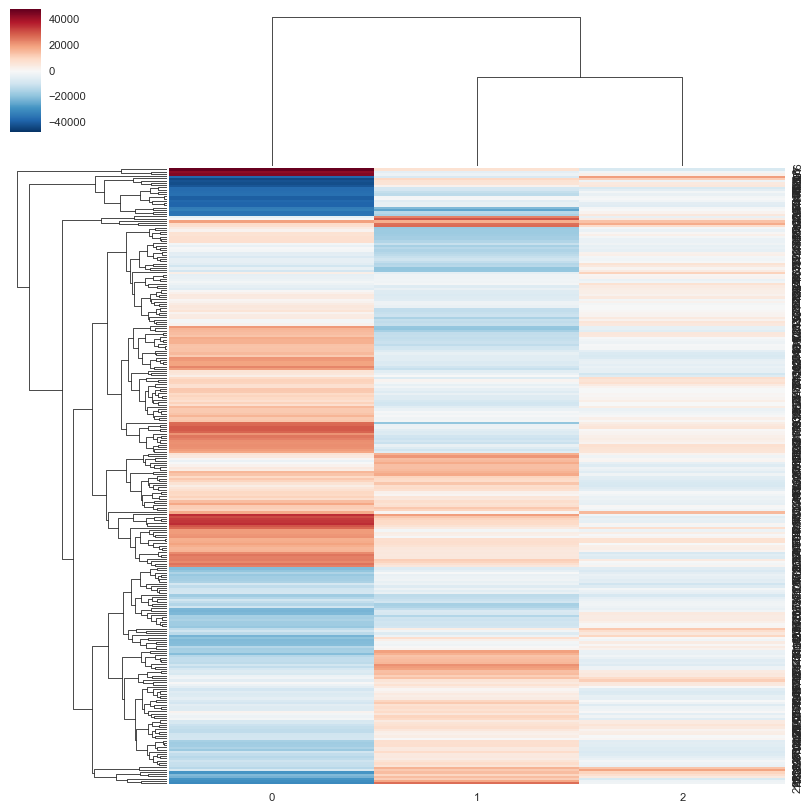

In [92]:
from sklearn.decomposition import PCA
from seaborn import heatmap

sns.set(context='paper')
pca3 = PCA(n_components=3) # TODO: Pick a more deliberate n_components
exp_pca3 = pca3.fit_transform(exp)

figure(figsize=(10, 10))
clustermap = sns.clustermap(exp_pca3) # TODO: Scan the literature to see what kind of clustering/metrics are commonly used
clustermap.savefig("clustermap.pdf")

Cool! There are some very clear relationships using the first principal component.

There are some nuances to take into account though: there are two important parameters in clusterplot, *method* and *metric* that are passed to a scipy function scipy.cluster.hierarchy.linkage(y, method, metric) https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In short, it first calculates the distance between all the pairs of points (default: euclidean distance) and then clusters the closest points (default: nearest neighbor search), then iterates. The dendrogram is a representation of this hierarchical agglomerative clustering. Note: We also did PCA before the clustering needed in heatmap since just exp causes it to surpass its maximum recursion depth.

Let's see just the first few levels of the dendrogram.

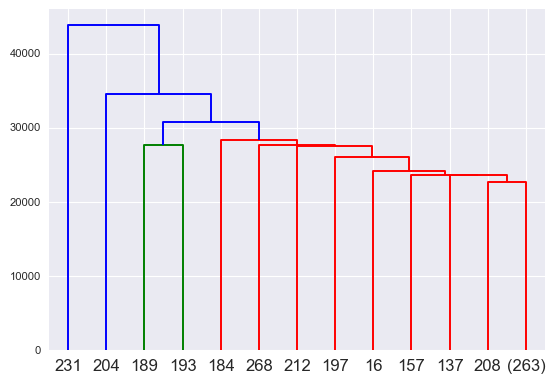

In [88]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

dist = pdist(exp_pca3, metric='euclidean') # TODO: Explore some of the neat metric options (like Minkowski)
                                             # TODO: Explore the copious spatial distance options for boolean vectors
link = hierarchy.linkage(dist, method='single', metric='euclidean')
R = hierarchy.dendrogram(link, p=10, truncate_mode='level')

In a dendrogram, height corresponds to similarity — the larger the height, the more dissimilar the nodes. So in this case, we see that when we truncate the dendrogram to look at the top 10 clusters, that clusters 222, 62, 268, and 264 are the most similar.

**TODO:** It might be a good idea to visualize all our clustering algorithms with dendrograms, and see if we can draw correlations between cluster/gene similarities and survival times.

**TODO** It would be interesting to calculate the distance matrix between 2 or 3 people that have similar progression times.

There is definitely a lot more exploring to do, but I also want to start playing with machine learning algorithms.

# Classification

## Model 1: Random Forest Feature Selection + Logistic Regression Classification with k-fold Nested Cross-Validation

One attempt out of many to make a classifier. To relate this to the problem — it makes sense that patients can be ranked by their probability of getting classified as "progressed". **TODO:** Add the other attempts to this notebook.

### Hyper-parameter Selection Notes

    Data used to optimize the model should not be used to evaluate the model — namely, data used to feature select and optimize hyperparameters cannot be used to cross-validate the model.

    The solution is to use nested cross-validation (which is basically a combinatoric train-cross val-test scheme), or evaluate using the .632+ bootstrapping rule (or just use a proper cross-validation and test set that is entirely separate from training data, but this is unfeasible with a small sample number.

    References:
    http://www.pnas.org/content/99/10/6562.full.pdf
    http://jmlr.org/papers/volume11/cawley10a/cawley10a.pdf
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
    http://stats.stackexchange.com/questions/11602/training-with-the-full-dataset-after-cross-validation
    http://stats.stackexchange.com/questions/102842/what-to-do-after-nested-cross-validation -- has useful pseudocode
    http://stats.stackexchange.com/questions/257361/nested-cross-validation-for-feature-selection-and-hyperparameter-optimization -- my    question

    Pseudocode:
    # For each parameter set p; **parameter selection**
        # Split the set S' of N' available samples into num_samples' disjunct sets
        # **inner cross-validation**
        # for j=1 to num_splits'
                # Train the classifier on the training set S'' = S' \ S'_j
                # Calculate the test error on the parameter test set S'_j
            # Compute the inner CV test error
        # Select parameter set p with the minimum error

        # Train classifier with selected parameter set on S'
        # Calculate test error on S_i
    # Calculate outer CV test error

### Feature Selection Notes

Iterative Pearson correlation coefficients: Generates Pearson correlation coefficients in the initial m samples x n features feature space to get an mxm matrix, which is then interpreted as m-samples m-features, finds the Pcc again, and iterates; reveals sample similarity hiding in higher-order correlation features, enlarge weak patterns underlying the raw dataset, and preserve the balanced independent relationship.
http://nar.oxfordjournals.org/content/early/2013/06/12/nar.gkt343.full
    
    • Doesn't seem hard to implement and since all of the patients have myeloma, this might be a better way to find finer differences between the patients — ones that would lead to progression time differences.
    
    • Maybe a NN can be made using this? dunno
    
    • The accuracy of both k-means clustering and naive Bayes jumped like 15% when just using first-order coefficients.
    
    • Sample workflow: Select top 1000 features using F-test, then iPcc
    
    • "The reduced dimensionality allows rapid and accurate computation of the global optimum of many clustering and classification algorithms and thus improves accuracy." -- maybe this can be combined with
    
    • "However, iPcc is not an independent algorithm for disease class discovery or prediction. It provides an effective means to underpin the underlying patterns embedded within the gene expression data sets from the feature extraction perspective. Therefore, it can be used in combination with other clustering, classification, feature selection and feature extraction algorithms, as demonstrated in the results section."
    
    • Can't find a wrapper function for the iPcc, maybe I can make one and give it to scikit-learn
    
    • I think this might be called something else — "hierarchal clustering", or maybe we can use existing clustering algorithms iteratively with the Pearson correlation coefficient as the metric.

Instead of approaching this problem as finding features to predict cancer (because they already all have cancer), perhaps approaching it from a cancer subtyping problem (Ren X, Wang Y, Wang J, Zhang XS. A unified computational model for revealing and predicting subtle subtypes of cancers. BMC Bioinformatics 2012;13:70.) might be fruitful, where the subtypes are how quickly they progress.


Before we do all that, we'll need to assign X and y variables.

In [107]:
def alignData(df1, df2):
    '''
    Create dataframes that have the same row indices (same samples)
    Args:
        df1 numpy ndarray; a dict with pandas.Series, arrays, constants, or list-like values; pandas.DataFrame
        df2 numpy ndarray; a dict with pandas.Series, arrays, constants, or list-like values; pandas.DataFrame
    Return: A tuple of DataFrames with the same row indices.

    Also tries to be fancy with exception handling.
    '''
    if not isinstance(df1, pd.DataFrame):
        df1 = pd.DataFrame(df1) # There is not a scope issue because df1 and df2 are passed parameters.
    if not isinstance(df2, pd.DataFrame):
        df2 = pd.DataFrame(df2)

    index = (df1.index & df2.index)
    ret1 = df1.loc[index, :]
    ret2 = df2.loc[index, :]
    return (ret1, ret2)

X, y = alignData(exp, labels.P)
y = np.ravel(y) # for sklearn

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, cross_val_predict, validation_curve, RandomizedSearchCV

def nestedCrossValidation(X, y, pipeline, param_distributions, scoring, outer, inner):
    '''
    Estimates generalization error of the underlying model and its hyper-parameter search using 10-fold stratified cross validation for both the inner and outer validations and prints out 10 scores.

    Params:
        X, y : Data and associated labels
        pipeline: Metaestimator generated from sklearn.pipeline.Pipeline - has the sequence of transforms and fits the estimator to the data at the end
        param_distributions : Dictionary with parameters names (string) as keys and distributions of parameters to try.
        scoring : One of sklearn's scoring functions
        outer, inner: cross-validators

    Outputs:
        Cross-validation scores for each outer fold.
        TODO: Find a way to print out the optimal parameters in each fold so we can examine stability of the hyperparameters as well
    '''
    rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_distributions, verbose=1, scoring='roc_auc', cv=inner)
    rs.fit(X, y)
    scores = cross_val_score(rs, X, y, cv=outer)
    print("Cross validation scores: {}".format(scores) + '\n' + "Best hyper-parameter score: {}".format(rs.best_score_) + "\n" "Optimized parameters: {}".format(rs.best_params_) + "\n")

rf_feat_imp = RandomForestClassifier(criterion='entropy')
feat_selection = SelectFromModel(rf_feat_imp)
pipe = Pipeline([('fs', feat_selection), ('fm', LogisticRegression())])

params = {
     'fs__estimator__n_estimators': np.arange(1, 100),
     'fs__estimator__min_samples_split': np.arange(2, 51),
     'fm__C' : 10. ** np.arange(-3, 3)
    }

outer = StratifiedKFold(n_splits=3)
inner = StratifiedKFold(n_splits=3)
nestedCrossValidation(X, y, pipe, params, 'roc_auc', outer, inner) # Cross validation scores: [ 0.46428571  0.63095238  0.8452381   0.70238095  0.79166667  0.60119048 0.61111111  0.76388889  0.68055556  0.63194444] — seems unstable.

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.0s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.6s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   14.4s finished


Cross validation scores: [ 0.64188034  0.51025641  0.50512821]
Best hyper-parameter score: 0.6051282051282052
Optimized parameters: {'fs__estimator__n_estimators': 73, 'fs__estimator__min_samples_split': 27, 'fm__C': 0.001}



Cross-validation scores show high variance - indicating instability of hyper-parameters. Do more testing.

## Model 2: LASSO for Feature Selection and GLM creation + Cox Regression for Survival Analysis

lambda(t | x) = lambda_0(t) * exp(Bx) --> Cox Regression; Bx is just a generalized linear model.

**TODO:** Use cross-validation instead of test/train split

### LASSO

**TODO** Compile your citations and notes

In [111]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso

lasso = linear_model.Lasso(alpha=1, max_iter=10000)
lasso.fit(X, y)
coef = lasso.coef_
nonzero_idx = np.nonzero(coef)[0] # Gets the indices of the nonzero coefficients; 171 features
X_lasso = X.iloc[:, nonzero_idx]

### Cox Regression

Look into Gaussian Processes as well

3 approaches to fitting survival models (http://data.princeton.edu/wws509/notes/c7s3.html):
    1) Parametric
    2) Semi-parametric
    3) Non-parametric
        - Cox. Functions by leaving the baseline hazard unspecified and relies on a partial likelihood function.

Although I think Cox is the approach that should be taken, it doesn't seem to be working the way I am using it. Read up on how Cox is used in the context of disease progression and genomics.

"SURVIV for survival analysis of mRNA isoform variation" (2016) - http://www.nature.com/articles/ncomms11548

Note: You've been doing it wrong this entire time - censored doesn't necessarily mean "NaN" values:

* Right censored: Failure happens *after* a given point — survival analysis asssumes failure will happen, it's just a matter of time

Therefore, for our "duration" data, if labels.TP = NaN, we should put in labels.TO's value


In [144]:
from lifelines import AalenAdditiveFitter, CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index
from scipy import stats

y = alignData(X_lasso, labels)[1] 
TP_nan_idx = (y.P==False)
y.TP[TP_nan_idx] = y.TO[TP_nan_idx] # TODO: Handle warnings

x_trn, x_tst, y_trn, y_tst = train_test_split(X_lasso, y, test_size=0.2, stratify=y.P)
x_trn['d'] = y['TP']
x_trn['e'] = y['P']

cf = CoxPHFitter()
cf.fit(x_trn, 'd', 'e')
lt_exp = cf.predict_expectation(x_tst)
display(lt_exp)

# Lifelines uses the concordance_index as a metric
# Similar to roc_auc — 0.5 is random, 1/0 is perfect concordance/anti-concordance; values are typically between 0.6-0.7
concordance_index(y_tst.TP, lt_exp, y_tst.P) # 0.57

,0
125,520.500000
13,520.500000
91,351.500277
72,167.862705
62,520.500000
61,520.499988
108,520.500000
93,520.500000
227,73.318542
179,44.000000


0.53026315789473688